In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
sns.set(style='dark', palette='muted', color_codes=True)
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
import plotly.express as px

In [2]:
from sklearn.impute import SimpleImputer 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,OrdinalEncoder,MinMaxScaler,StandardScaler 
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.ensemble import RandomForestRegressor 
from sklearn.cluster import KMeans 
from sklearn.pipeline import Pipeline 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import r2_score, mean_squared_error, silhouette_score, accuracy_score, confusion_matrix
from sklearn.decomposition import PCA

In [3]:
data = pd.read_csv(r'c:\Github\Sol\the_data\data-lab-4-heart.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [4]:
mis_val = data.isna().sum() * 100/len(data)
mis_val.sort_values(ascending=False)

age         0.0
sex         0.0
cp          0.0
trestbps    0.0
chol        0.0
fbs         0.0
restecg     0.0
thalach     0.0
exang       0.0
oldpeak     0.0
slope       0.0
ca          0.0
thal        0.0
target      0.0
dtype: float64

In [5]:
# mean_imp = SimpleImputer(missing_values=np.NaN, strategy='mean')

# data[['ALP','CHOL','ALB','ALT','PROT']] = mean_imp.fit_transform(data[['ALP','CHOL','ALB','ALT','PROT']])

In [6]:
mis_val = data.isna().sum() * 100/len(data)
mis_val.sort_values(ascending=False)

age         0.0
sex         0.0
cp          0.0
trestbps    0.0
chol        0.0
fbs         0.0
restecg     0.0
thalach     0.0
exang       0.0
oldpeak     0.0
slope       0.0
ca          0.0
thal        0.0
target      0.0
dtype: float64

In [7]:
data.duplicated().sum()

data.drop_duplicates(inplace=True, ignore_index=False, subset=None, keep='first')

data.duplicated().sum()

0

<AxesSubplot:title={'center':'Correlation Matrix'}>

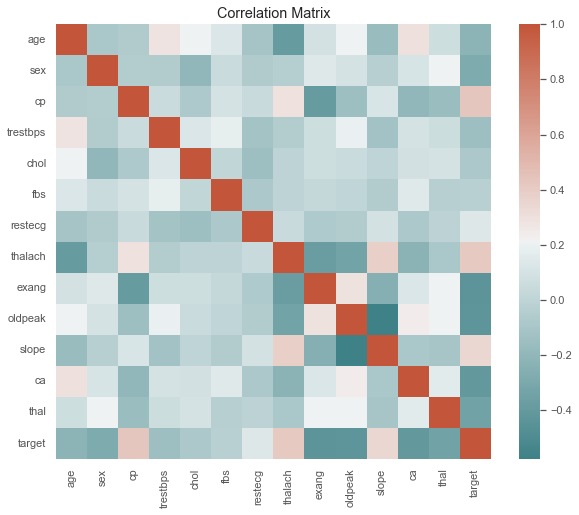

In [8]:
f,ax = plt.subplots(figsize=(10,8))

data_corr = data.corr()

ax.set_title('Correlation Matrix')
sns.heatmap(data_corr, mask=np.zeros_like(data_corr, dtype=np.bool_),cmap=sns.diverging_palette(200,20, as_cmap=True), ax=ax, square=True)

In [9]:
num_val = ['age','trestbps','chol','thalach','oldpeak']
cat_val = ['sex', 'cp', 'restecg', 'exang', 'slope', 'ca', 'thal']

In [10]:
colm_transf = ColumnTransformer( 
    [ 
        ('num', StandardScaler(), num_val),
        ('cat', OrdinalEncoder(), cat_val)
    ]
)

In [11]:
y = data.target 
x = data.drop(columns=['target'])

In [12]:
x = pd.DataFrame(colm_transf.fit_transform(x))
x

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.949794,0.764066,-0.261285,0.018826,1.084022,1.0,3.0,0.0,0.0,0.0,0.0,1.0
1,-1.928548,-0.091401,0.067741,1.636979,2.118926,1.0,2.0,1.0,0.0,0.0,0.0,2.0
2,-1.485726,-0.091401,-0.822564,0.980971,0.307844,0.0,1.0,0.0,0.0,2.0,0.0,2.0
3,0.174856,-0.661712,-0.203222,1.243374,-0.209608,1.0,1.0,1.0,0.0,2.0,0.0,2.0
4,0.285561,-0.661712,2.080602,0.587366,-0.382092,0.0,0.0,1.0,1.0,2.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
297,0.285561,0.478910,-0.106449,-1.161988,-0.727060,0.0,0.0,1.0,1.0,1.0,0.0,3.0
298,-1.042904,-1.232023,0.338703,-0.768384,0.135360,1.0,3.0,1.0,0.0,1.0,0.0,3.0
299,1.503322,0.707035,-1.035462,-0.374779,2.032684,1.0,0.0,1.0,0.0,1.0,2.0,3.0
300,0.285561,-0.091401,-2.235438,-1.511859,0.135360,1.0,0.0,1.0,1.0,1.0,1.0,3.0


In [13]:
x_train,x_test,y_train,y_test = train_test_split(x,y, random_state=42, test_size=0.3)

In [14]:
logreg = LogisticRegression()

logreg.fit(x_train,y_train)

y_true = y_test
y_pred = logreg.predict(x_test)

accu_scr = accuracy_score(y_true,y_pred).round(3)

mod_perf = pd.DataFrame( [
    'LogisticRegression', accu_scr]
).transpose()

mod_perf.columns = ['Method', 'LogReg Accu Test']
mod_perf

,Method,LogReg Accu Test
0,LogisticRegression,0.824


In [15]:
knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(x_train,y_train)

y_pred = knn.predict(x_test)

acc_scr = accuracy_score(y_true,y_pred)

acc_scr

0.8021978021978022

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Values', ylabel='True Values'>

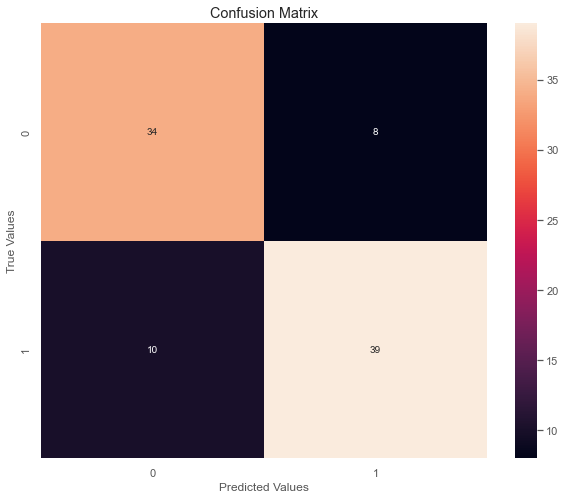

In [16]:
f,ax = plt.subplots(figsize=(10,8))
ax.set_title('Confusion Matrix')

conma_dic = { 
    'y_true':y_true,
    'y_pred':y_pred
}

conma_cols = pd.DataFrame( 
    conma_dic, columns=['y_true', 'y_pred']
)

confusion_matrix = pd.crosstab(
    conma_cols['y_true'], conma_cols['y_pred'], rownames=['True Values'], colnames=['Predicted Values']
)

sns.heatmap(confusion_matrix, annot=True, ax=ax)



c:\Users\amunv\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'Confusion Matrix'}>

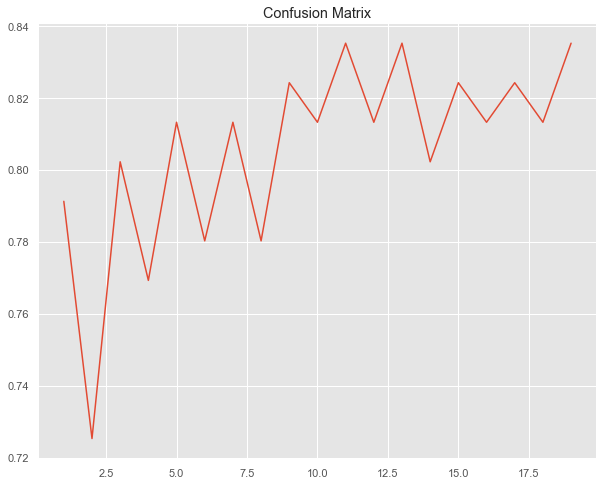

In [17]:
accuracies = []

for N in range(1,20):

    knn = KNeighborsClassifier(n_neighbors=N)

    knn.fit(x_train,y_train)

    y_pred = knn.predict(x_test)
    y_true = y_test 

    accu = accuracy_score(y_true,y_pred)

    accuracies.append(accu) 


accuracies = np.array(accuracies)

f,ax = plt.subplots(figsize=(10,8))

ax.set_title('Confusion Matrix')

sns.lineplot(np.arange(1,20), accuracies, ax=ax)

In [18]:
best_k = 1 + np.argmax(accuracies)

best_accu = np.max(accuracies)

k_accu = pd.DataFrame( 
    [ 
        'KNeighborsClasifier', best_k, best_accu
    ]
).transpose()

k_accu.columns = ['Method', 'Best K', 'Best Accu']

k_accu

,Method,Best K,Best Accu
0,KNeighborsClasifier,11,0.835165
